# Testing the first generations method

In [1]:
%load_ext autoreload
%matplotlib notebook
%matplotlib notebook 

import numpy as np
import matplotlib.pyplot as plt
import sys
import logging

import ompy as om
# %matplotlib inline

%autoreload 2

## A) Spectrum generated (by dicebox(?)) from AC

In [2]:
allgen = om.Matrix(path="testcorr_part.m")

<IPython.core.display.Javascript object>


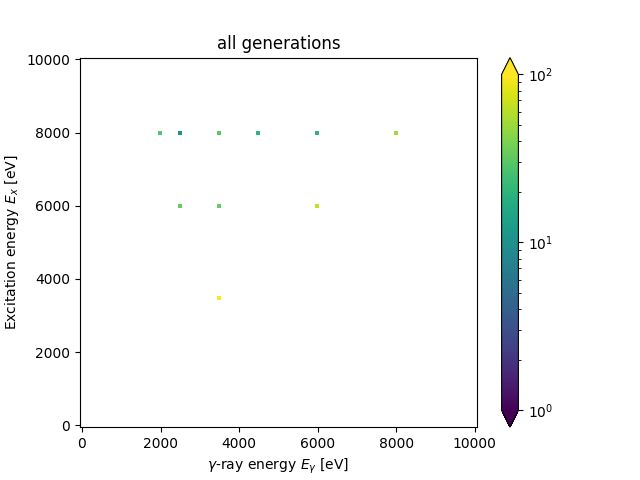

<IPython.core.display.Javascript object>


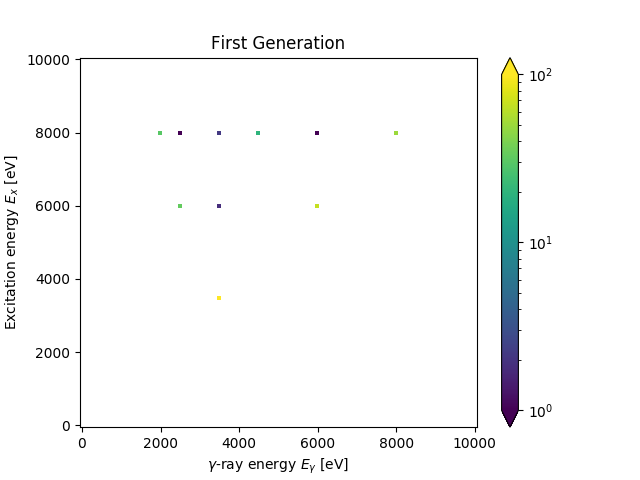

(<matplotlib.collections.QuadMesh at 0x7ff48bfb82b0>,
 <Figure size 640x480 with 2 Axes>)

In [3]:
firstgen = om.FirstGeneration()
primary = firstgen(allgen)
allgen.plot(vmin=1, vmax=100, scale="log", title="all generations");
primary.plot(vmin=1, vmax=100, scale="log")

<IPython.core.display.Javascript object>


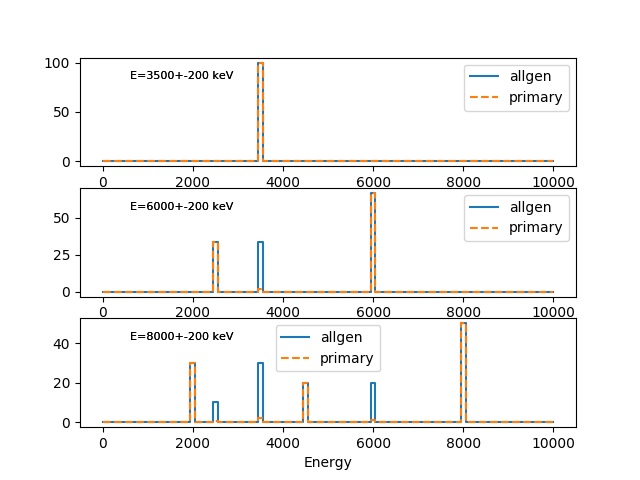

In [4]:
def plot_projections(mat, label, axes, Eproject, **kwargs):
    for i, E in enumerate(Eproject):
        ax = axes[i]
        dE=200
        mat.plot_projection(ax=ax, axis="Eg", Emin=E-dE, Emax=E+dE, label=label, **kwargs)
        ax.text(0.1, .8, f"E={E:.0f}+-{dE:.0f} keV",transform=ax.transAxes, fontsize=8)

Eproject = [3500, 6000, 8000] 
fig, axes = plt.subplots(3,1)

plot_projections(allgen, "allgen", axes, Eproject)
plot_projections(primary, "primary", axes, Eproject, linestyle="--")
for ax in axes:
    ax.legend()
plt.show()

What do you think about the results? To me it seems like the lower generations were deleted quite nicely. But are the proportions correct? I don't have the "true" primary spectrum o compare to, yet.

## B) Other simple mock spectra

In [5]:
# logger = om.introspection.get_logger('firstgeneration', 'DEBUG')
def normalize_rows(array: np.ndarray) -> np.ndarray:
    """ Normalize each row to unity """
    return om.div0(array, array.sum(axis=1).reshape(array.shape[1], 1))

def generate_simple_allgen(E, xs=None):
    values = np.ones((E.size, E.size))
    values = np.tril(values)
    values = normalize_rows(values)
    primaries = om.Matrix(values=values, Eg=E, Ex=E)
    allgen = firstgen.allgen_from_primary(primaries, xs)
    return allgen, primaries

**Note that the results depend on the energy grid we send in due to some default values for the multiplicity estimation**

<IPython.core.display.Javascript object>


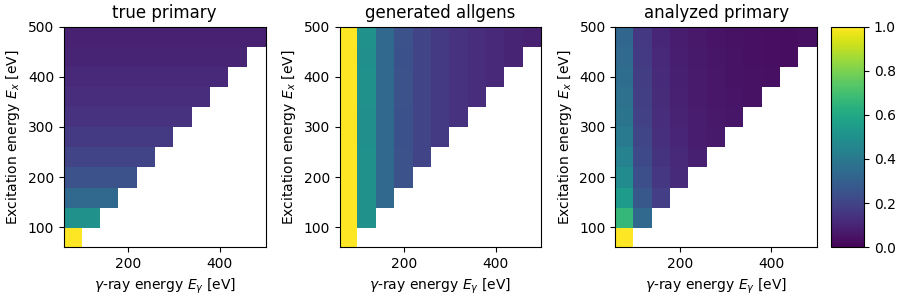

<IPython.core.display.Javascript object>


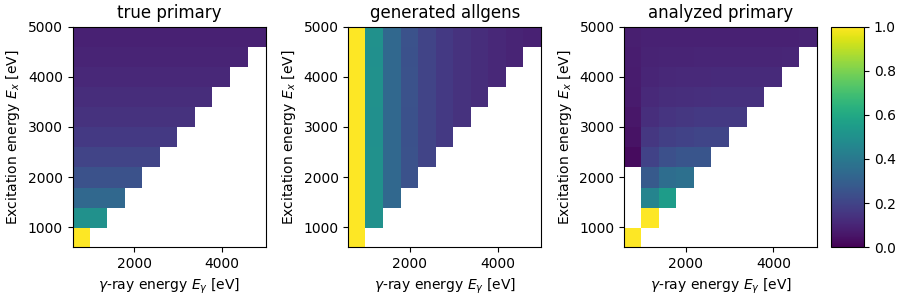

<IPython.core.display.Javascript object>


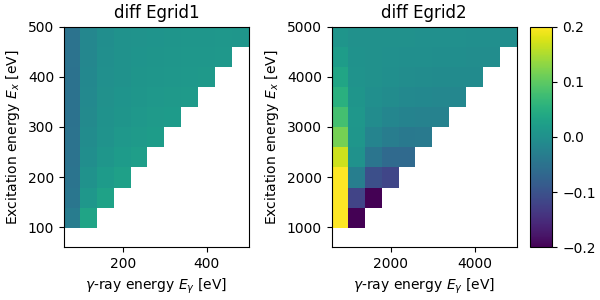

In [9]:
#plot settings
vmin = 0
vmax = 1

# first fg / first E grid
E = np.linspace(1,5,11)*1e2
allgen, primaries = generate_simple_allgen(E)
primary_analyzed = firstgen(allgen)
primary_analyzed.values = normalize_rows(primary_analyzed.values)

fig, axes = plt.subplots(1,3, figsize=(9,3), constrained_layout=True)
primaries.plot(ax=axes[0], title="true primary", vmin=vmin, vmax=vmax)
allgen.plot(ax=axes[1], title="generated allgens", vmin=vmin, vmax=vmax)
lines, ax, _ = primary_analyzed.plot(ax=axes[2], title="analyzed primary", vmin=vmin, vmax=vmax)
fig.colorbar(lines, ax=ax)

diff1 = primaries-primary_analyzed

# second fg / second E grid
E = np.linspace(1,5,11)*1e3
allgen, primaries = generate_simple_allgen(E)
primary_analyzed = firstgen(allgen)
primary_analyzed.values = normalize_rows(primary_analyzed.values)

fig, axes = plt.subplots(1,3, figsize=(9,3), constrained_layout=True)
primaries.plot(ax=axes[0], title="true primary", vmin=vmin, vmax=vmax)
allgen.plot(ax=axes[1], title="generated allgens", vmin=vmin, vmax=vmax)
lines, ax, _= primary_analyzed.plot(ax=axes[2], title="analyzed primary", vmin=vmin, vmax=vmax)
fig.colorbar(lines, ax=ax)

diff2 = primaries-primary_analyzed

# plot the differences
fig, axes = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)
diff1.plot(ax=axes[0], title="diff Egrid1", scale="linear", vmin=-1, vmax=1)
lines, ax, _ = diff2.plot(ax=axes[1], title="diff Egrid2", scale="linear", vmin=-0.2, vmax=0.2)
fig.colorbar(lines, ax=ax)

## Adding a cross-section dependence: Does not change the results

<IPython.core.display.Javascript object>


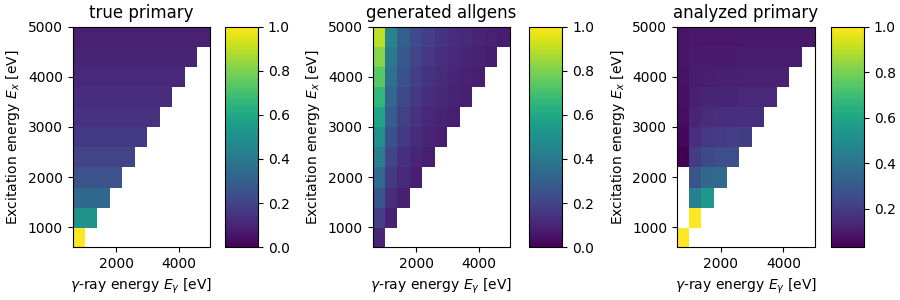

<IPython.core.display.Javascript object>


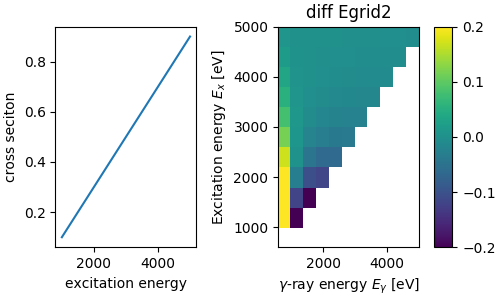

In [12]:
E = np.linspace(1,5,11)*1e3
xs = np.linspace(0.1,0.9,11)
allgen, primaries = generate_simple_allgen(E, xs)
primary_analyzed = firstgen(allgen)
primary_analyzed.values = normalize_rows(primary_analyzed.values)



fig, axes = plt.subplots(1,3, figsize=(9,3), constrained_layout=True)
lines, ax, _= primaries.plot(ax=axes[0], title="true primary", vmin=vmin, vmax=vmax)
fig.colorbar(lines, ax=ax)
lines, ax, _= allgen.plot(ax=axes[1], title="generated allgens", vmin=vmin, vmax=vmax)
fig.colorbar(lines, ax=ax)
lines, ax, _= primary_analyzed.plot(ax=axes[2], title="analyzed primary")
fig.colorbar(lines, ax=ax)

diff2 = primaries-primary_analyzed


# plot the differences
fig, axes = plt.subplots(1, 2, figsize=(5,3), constrained_layout=True)
axes[0].plot(E, xs)
axes[0].set_xlabel("excitation energy")
axes[0].set_ylabel("cross seciton")

lines, ax, _ = diff2.plot(ax=axes[1], title="diff Egrid2", scale="linear", vmin=-0.2, vmax=0.2)
fig.colorbar(lines, ax=ax)

For a "reasonable energy grid" -- somethings that resembles our data, this again isn't perfect, but it is probably all right. Can we quantify this better? Should the be used in a unit test?